In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import numpy as np
from nn_magnetics.dataset import get_one_magnet, ChiMode

data = np.load("../data/isotropic_chi/eval/data_1.npz")
X, B = get_one_magnet(ChiMode.ISOTROPIC, data)

B_demag_grid, B_ana_grid = B[:, :3], B[:, 3:]

a = X[0, 0]
b = X[0, 1]
chi = X[0, 2]
grid = X[:, 3:]
polarization_reduced = data["demagnetization_factor"]

point = grid[200]
B_ana_point = B_ana_grid[200]
B_demag_point = B_demag_grid[200]

In [16]:
B_demag_point

array([ 5.95244628e-09,  1.48385380e-02, -4.08312651e-02])

In [17]:
from magpylib.magnet import Cuboid

magnet_ana = Cuboid(dimension=(a, b, 1), polarization=(0, 0, polarization_reduced))
B_ana = magnet_ana.getB([a, b, 1] * point)

# Check analytical solution matches saved data
if np.allclose(B_ana, B_ana_point):
    print(B_ana)


[ 5.94755773e-09  1.43098384e-02 -3.99383054e-02]


In [18]:
from nn_magnetics.model import Network
import torch

model = Network(in_features=6, hidden_dim_factor=6, out_features=3).to("cpu", dtype=torch.float64)
model.load_state_dict(torch.load("../results/isotropic_chi_v2/different-aardvark-14/weights.pt", weights_only=True))
correction_factors = model(torch.tensor([a, b, chi, *point], dtype=torch.float64))
B_corrected = correction_factors.detach().numpy() * B_ana_point

In [19]:
B_corrected

array([ 5.96200122e-09,  1.48470464e-02, -4.08394168e-02])

In [20]:
a, b, chi

(np.float64(1.7817964606037768),
 np.float64(2.2310112892055325),
 np.float64(0.6027633760716439))

In [21]:
point

array([5.61231331e-07, 9.00000287e-01, 2.00000920e-01])

In [22]:
from magpylib.magnet import Cuboid

magnet = Cuboid(dimension=(a, b, 1), polarization=(0, 0, polarization_reduced), susceptibility=chi)
B_corrected_magpylib = magnet.getB([a, b, 1] * point)

In [23]:
np.allclose(B_corrected, B_corrected_magpylib)

True

In [11]:
from nn_magnetics.optimize.fit import read_hdf5, prepare_measurements
import matplotlib.pyplot as plt

def show(arr, *axs):
    if "x" in axs:
        plt.plot(arr[:,0]/1000, label="x")
    if "y" in axs:
        plt.plot(arr[:,1]/1000, label="y")
    if "z" in axs:
        plt.plot(arr[:,2]/1000, label="z")
    
    plt.legend()
    plt.show()

positions1, positions2_rotated, field_measured1, field_measured2_rotated, = prepare_measurements("../scans")


/Users/jacksmith/Documents/PhD/magpylib/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cuboid(id=5169170192) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()
/Users/jacksmith/Documents/PhD/magpylib/magpylib/_src/obj_classes/class_BaseExcitations.py:394: MagpylibDeprecationWarning: Cuboid(id=5168482592) received a very low magnetization. In Magpylib v5 magnetization is given in units of A/m, while polarization is given in units of T.
  self._magnetization_low_warning()


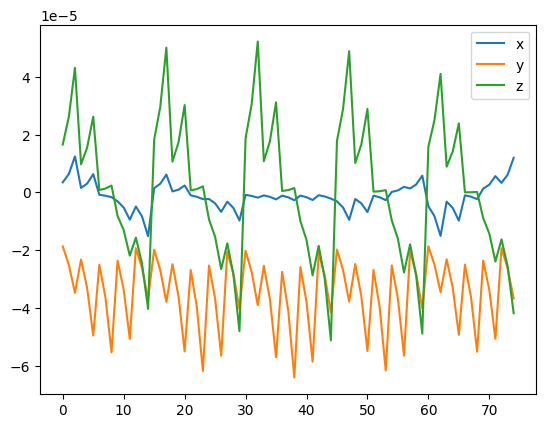

In [12]:
show(field_measured1, "x", "y", "z")

In [13]:
show(side)

NameError: name 'side' is not defined